### Visualizing Attention Map in Vision Transformer (ViT)

In the previous notebook, we went indepth discussing the architecture details of a ViT. We learned that the key characteristic of a vision transformer is its ability to attend to all patches of an image simultaneously through each head in its multi-head attention mechanism.  This enables the model to capture complex relationships between patches in parallel. Combined with effective training strategies, this capability distinguishes vision transformers from other architectures, achieving SOTA performance on the ImageNet and other well known datasets.

<img src = "https://learnopencv.com/wp-content/uploads/2024/10/ViT-base-patch16-224-timm-feature-attention-map-notebook-2.png">

**What is a Attention Map?**



An attention map is a visualization of attention weights in transformer architectures. Similar to Explainable AI (XAI) approaches like Gradcam which visualizes feature map activations, attention maps for ViT, shows how strongly each image patch attends to other patches. This is based on learned query-key interactions followed by softmax normalization. These weights, typically range from 0 to 1, to form a probability distribution across patches. Multiple attention heads produce parallel attention maps, each potentially focusing on different aspects of the image. These visualizations help interpret the model's decision making process by revealing which spatial relationships the model considers significant at different blocks and layers.

In this notebook, we will explore how to visualize the attention map produced by a ViT model using timm library's AttentionExtract utility.

## Table of Contents

* [1. Import Dependencies](#1.-Import-Dependencies)
* [2. Load the image](#2.-Load-the-image)
* [3. Load Timm ViT Model](#3.-Timm-ViT-Model)
   
* [4. Inference](#4.-Inference)
* [5. Extracting Attention Output](#5.-Extracting-Attention-Output)
* [6. Interpretation](#6.-Interpretation)
* [7. Conclusion](#7.-Conclusion)
* [8. References](#8.-References)

### 1. Import Dependencies

In [1]:
!pip install torchinfo -q

In [5]:
from typing import Dict
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #for colorbar handling
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from torchinfo import summary
from timm.utils import AttentionExtract
from timm.data import create_transform

#### Set seeds for reproducibility

In [ ]:
def seed_everything(SEED):

   np.random.seed(SEED)
   random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

seed_everything(0)

In [ ]:
device = "cpu"

### 2. Load the image



In [6]:
os.makedirs("input_data", exist_ok = True)

In [8]:
!wget https://learnopencv.com/wp-content/uploads/2024/11/myrtle_warbler_01.jpg -O myrtle_warble.jpg

!wget -q "https://www.dropbox.com/scl/fi/n97l7mqpmyil8xdokywi9/imagenet_classes.txt?rlkey=ocnr2auobljyopgumqr5u87da&st=bued3ffo&dl=1" -O input_data/imagenet_classes.txt

--2025-06-06 01:04:06--  https://learnopencv.com/wp-content/uploads/2024/11/myrtle_warbler_01.jpg
Resolving learnopencv.com (learnopencv.com)... 141.193.213.11, 141.193.213.10
Connecting to learnopencv.com (learnopencv.com)|141.193.213.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19147 (19K) [image/jpeg]
Saving to: ‘myrtle_warble.jpg’

myrtle_warble.jpg   100%[===================>]  18.70K  --.-KB/s    in 0s      

2025-06-06 01:04:06 (117 MB/s) - ‘myrtle_warble.jpg’ saved [19147/19147]



In [ ]:
img_path = 'myrtle_warble.jpg'
image_size = 224 #input size expected by model

Orig Img Shape (700, 400)


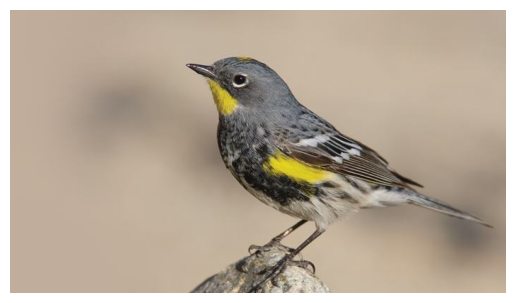

In [ ]:
img = Image.open(img_path).convert("RGB")

print("Orig Img Shape", img.size)

plt.imshow(img)
plt.axis('off')
plt.show()

### 3. Timm ViT Model

Unlike torchvision models, in `pytorch_timm_models` the attention weights and layers are easily accessible. Therefore we will load a `vit_base_patch16_224` model with `IMAGENET1K` pretrained weights. Additionally the `timm.create_model()` allows us to infer input image size dynamically thereby effectively handling the num patches being generated.

The following is a code snippet from [**vision_transformers.py**](https://github.com/huggingface/pytorch-image-models/blob/60f517c88327a64d44fb7259bb427c7658fdbb1b/timm/models/vision_transformer.py#L666) in timm repository that's responsible to handle dynamic input size.
```python
if self.dynamic_img_size:
    B, H, W, C = x.shape
    pos_embed = resample_abs_pos_embed(
        self.pos_embed,
        (H, W),
        num_prefix_tokens=0 if self.no_embed_class else self.num_prefix_tokens,
    )
    x = x.view(B, -1, C)
else:
    pos_embed = self.pos_embed
```

If `self.dynamic_img_size` is not enabled, the model defaults to using the pre-defined positional embeddings without resampling `(pos_embed = self.pos_embed)`.
In `x.view(B, -1, C)`, the -1 automatically calculates the number of patches based on the input size, flattening the image into a sequence of patches for the transformer.

After the model is created we will load in `eval()` mode and is moved to **cuda**


In [ ]:
import timm

timm.list_models(filter = "vit_base*")

['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32_clip_quickgelu_224',
 'vit_base_pa

In [ ]:
model_path = "vit_base_patch16_224"

timm.layers.set_fused_attn(False) #For fixing: RuntimeError: No node names found matching ['*attn.softmax'].

model = timm.create_model(
    model_path, pretrained = True)

model.eval().to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

There are **12 encoder blocks**, with an embedding dimension of **768**, a patch size of **16**, and a fully connected head for 1000 classes in the `vit_base_patch16_224` model we have loaded. It is an **86.6M** parameter model.

In [ ]:
summary(model, input_size = (1, 3, image_size, image_size),
        device = "cpu", row_settings = ["var_names"])

Layer (type (var_name))                  Output Shape              Param #
VisionTransformer (VisionTransformer)    [1, 1000]                 152,064
├─PatchEmbed (patch_embed)               [1, 196, 768]             --
│    └─Conv2d (proj)                     [1, 768, 14, 14]          590,592
│    └─Identity (norm)                   [1, 196, 768]             --
├─Dropout (pos_drop)                     [1, 197, 768]             --
├─Identity (patch_drop)                  [1, 197, 768]             --
├─Identity (norm_pre)                    [1, 197, 768]             --
├─Sequential (blocks)                    [1, 197, 768]             --
│    └─Block (0)                         [1, 197, 768]             --
│    │    └─LayerNorm (norm1)            [1, 197, 768]             1,536
│    │    └─Attention (attn)             [1, 197, 768]             2,362,368
│    │    └─Identity (ls1)               [1, 197, 768]             --
│    │    └─Identity (drop_path1)        [1, 197, 768]           

#### Visualize Patches

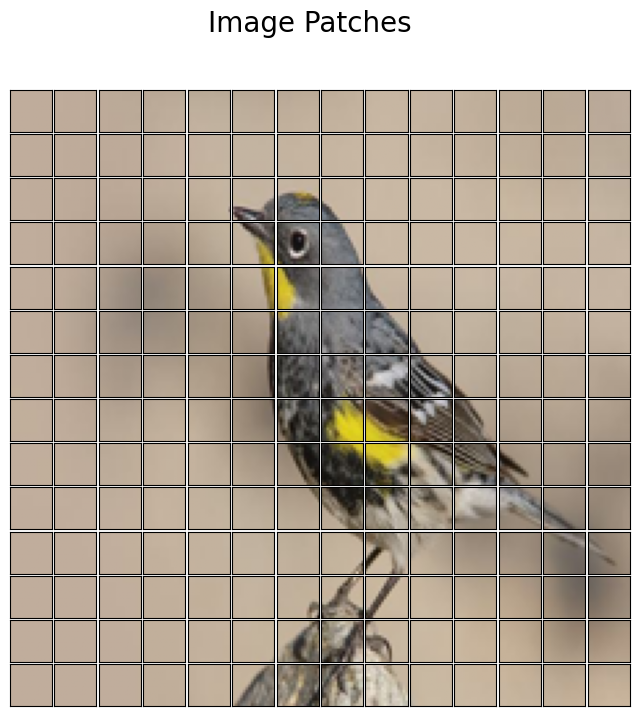

In [ ]:
patch_img = img.resize((224, 224))

# Convert to NumPy array
patch_img = np.array(patch_img)

# Clip values between 0 and 1 (normalization)
patch_img = np.clip(patch_img / 255.0, 0, 1)

# Define grid and patch size
image_size = 224  # Since we've resized the image
patch_size = 16   # Size of each patch
grid_size = image_size // patch_size  # This will give 14 (224 // 16)

num_patches = grid_size * grid_size  # Total number of patches = 14 x 14 = 196

# Create the figure for displaying patches
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Image Patches", fontsize=20)
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)

# Loop to display patches
for i in range(0, num_patches):  # Now, num_patches is 196

    x = i % grid_size  # Column position (cycles through 0 to grid_size-1)
    y = i // grid_size  # Row position (increments every grid_size patches)

    # Slice the patches: patch_img[y*16:(y+1)*16, x*16:(x+1)*16] will give (16, 16, 3)
    patch = patch_img[y * patch_size:(y+1) * patch_size, x * patch_size:(x+1) * patch_size, :]

    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# Show the figure
plt.show()

In [15]:
imagenet_classes = pd.read_csv(
    'input_data/imagenet_classes.txt',
     delimiter = ',',
     names = ['class_index', 'class_name']
)

imagenet_classes.head(500)

,class_index,class_name
0,0,tench
1,1,goldfish
2,2,great_white_shark
3,3,tiger_shark
4,4,hammerhead
...,...,...
495,495,china_cabinet
496,496,Christmas_stocking
497,497,church
498,498,cinema


### 4. Inference

In [ ]:
def common_transforms(image_size):
    """
    Returns a composed transformation pipeline for validation images.
    """
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [ ]:
transformed_img  = common_transforms(image_size)(img)

ip_img = transformed_img.unsqueeze(0).to(device)

with torch.no_grad():
    predictions = model.to(device)(ip_img)

print(predictions.shape)

torch.Size([1, 1000])


In [ ]:
softmax = nn.Softmax(dim=1)
probs = softmax(predictions)
print(probs.shape)

torch.Size([1, 1000])


The predicted class is incorrect as the ground truth class, **Myrtle Warbler**, is not part of ImageNet-1k.

In [ ]:
result = imagenet_classes.iloc[np.argmax(probs[0].detach().cpu().numpy())]
print(result)

class_index            10
class_name      brambling
Name: 10, dtype: object


### 5. Extracting Attention Output

The [AttentionExtract utility](https://github.com/huggingface/pytorch-image-models/blob/f689c850b90b16a45cc119a7bc3b24375636fc63/timm/utils/attention_extract.py#L9) from timm, provides a convenient way to visualize attention maps by extracting attention maps or specific intermediate activations. The utility is versatile, supporting both computation graph tracing (via the fx method) and module-based forward hooks (via the hook method).

**FX Method**
- The first method uses [PyTorch's FX Graph Mode](https://pytorch.org/docs/stable/fx.html) to trace the model’s computation graph, suitable for FX (Function Transform) compatible models (especially timm models).
- During intialization, `GraphExtractNet` wraps the model, capturing and storing outputts of specific nodes in the model's graph.
- It is more flexible to access intermediate computations using this method.


**Hook Method**

- The second method is to use the PyTorch forward hooks, to attach hooks to particular modules or layers of the model via `register_forward_hooks`. Thereby directly accessing intermediate outputs without tracing entire computation graph.
- The hooks are configured to capture activations from the relevant modules based on specified patterns or explicit layer names.

 Alternatively,

```python
extractor = AttentionExtract(model, method='fx', hook_type = 'forward_pre')
```

In this notebook, we will use FX metthod for simplicity.

In [ ]:
extractor = AttentionExtract(model, method='fx') #feature extractor

Then preprocessing utility is defined to read an image and normalize it using ImageNet mean and standard deviation via timm's `create_transform` function. By default, horizontal flip (hflip) augmentation is applied with a probability of `0.5`.

In [ ]:
def process_image(
    image: Image.Image,
    model: torch.nn.Module,
    extractor: AttentionExtract
) -> Dict[str, torch.tensor]:

    """Process the input image and get the attention map"""

    #Get correct transform for the model

    config = model.pretrained_cfg

    transform = create_transform(
        input_size = config['input_size'], #default: (224, 224)
        crop_pct = config['crop_pct'],     #default: no cropping
        mean = config['mean'],
        std = config['std'],
        interpolation = config['interpolation'], #default: bilinear
        is_training = False
    )

    #Preprocess the image
    tensor = transform(image).unsqueeze(0) #add batch

    #Extract the attention maps
    attention_maps = extractor(tensor)

    return attention_maps

Once the image is preprocessed and passed through the model, the softmax output from the extractor is a dictionary containing attention values for each block.

For eg.,
```python
{
    'block.0.attn.softmax': attention_map_tensor0,
    'block.1.attn.softmax': attention_map_tensor1,
    ...
}
```

In [ ]:
attention_maps = process_image(img, model, extractor)

print(attention_maps.keys())

# print(attention_maps)

dict_keys(['blocks.0.attn.softmax', 'blocks.1.attn.softmax', 'blocks.2.attn.softmax', 'blocks.3.attn.softmax', 'blocks.4.attn.softmax', 'blocks.5.attn.softmax', 'blocks.6.attn.softmax', 'blocks.7.attn.softmax', 'blocks.8.attn.softmax', 'blocks.9.attn.softmax', 'blocks.10.attn.softmax', 'blocks.11.attn.softmax'])


---

As we know, in ViTs prefix tokens usually refer to the class token. The `getattr` retrieves the `num_prefix_tokens` attribute from the model, defaulting to `1` assuming atleast single class token exists.

The attention can be fused across heads in different ways such as `mean`, `mean_std`, `min` and `max`.   [[Ref](https://huggingface.co/spaces/timm/timmAttentionViz/blob/main/app.py)]

However here we will focus on `head_fusion = "mean"` which averages the attention maps across all the heads.


In [ ]:
num_prefix_tokens = getattr(model, 'num_prefix_tokens', 1) ## Default to single class token [CLS] if not specified

head_fusion = 'mean'

Finally, we extract the class token's attention map, reshape it a 2D tensor and resize it to match the input image dimensions (224,224) to visualize attentions per block.  Since the model has 12 encoder blocks, we get 12 subplots, each representing the attention map of a different block.

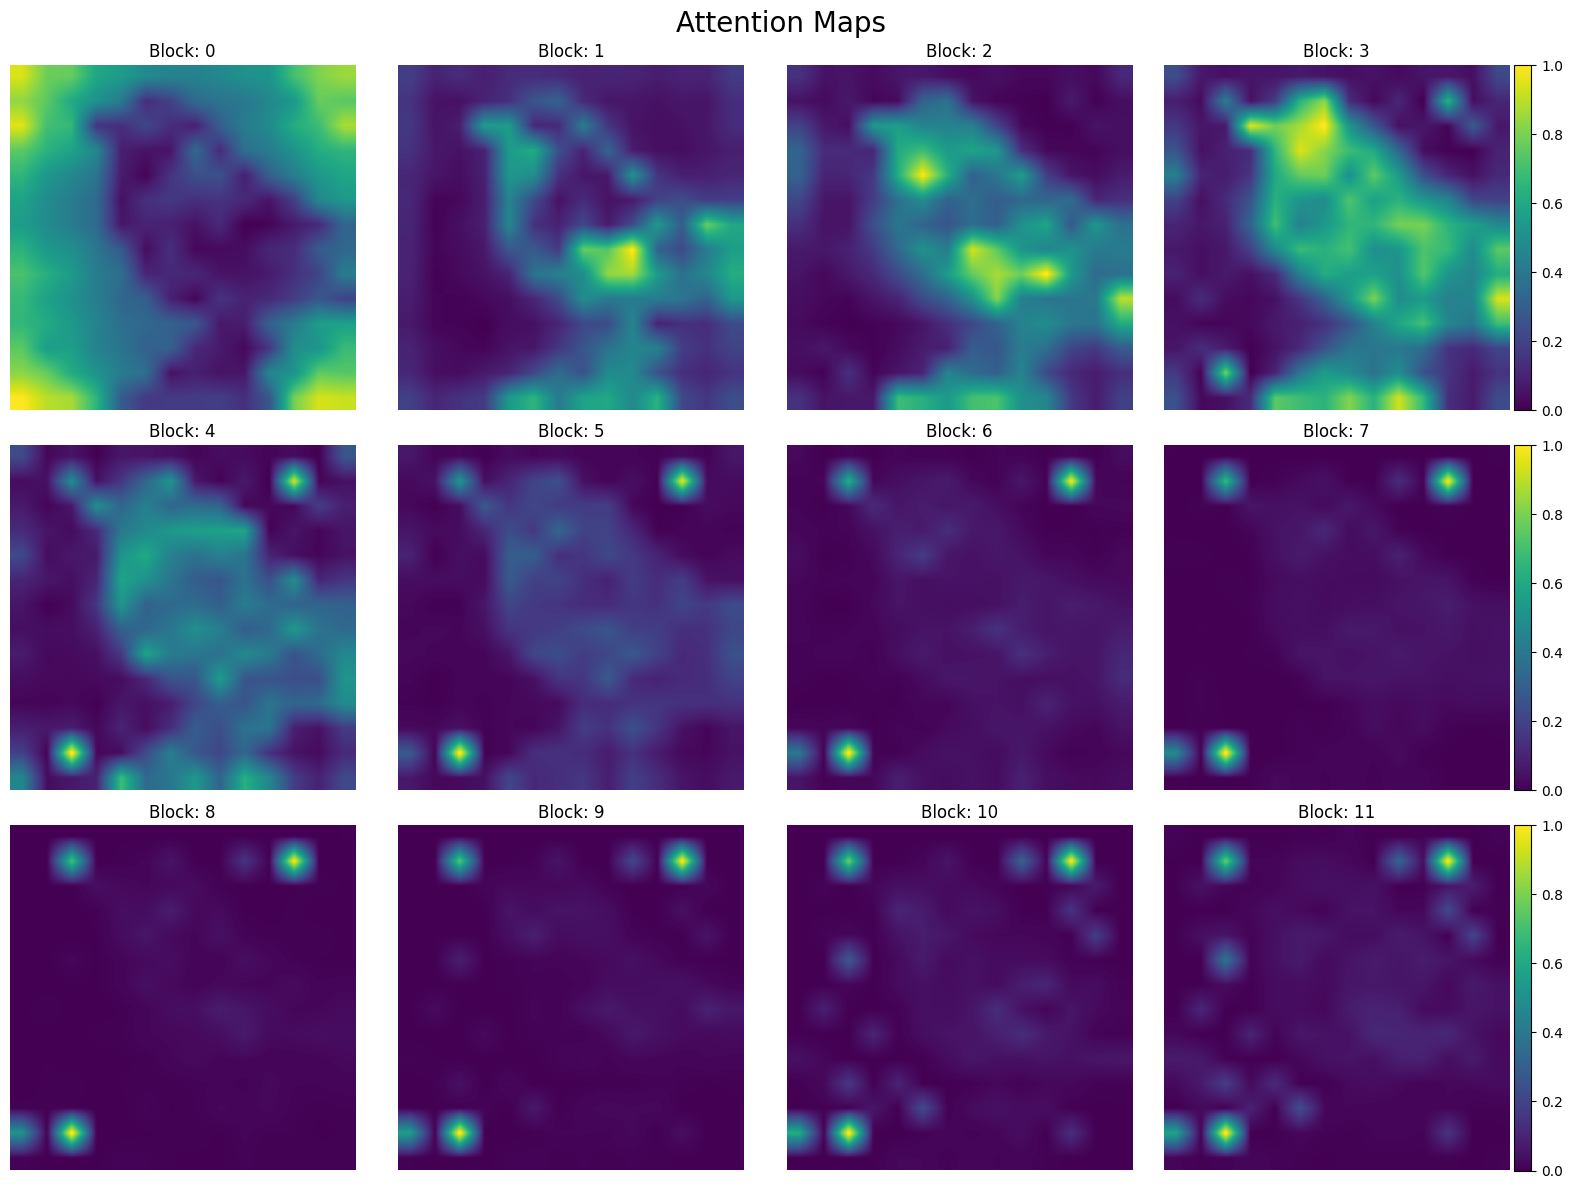

In [ ]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12)) #Create a 3x4 grid of subplots
fig.suptitle("Attention Maps", fontsize = (20))
axes = axes.flatten() # Flatten the 2D array of subplots into a 1D array

for i, (layer_name, attn_map) in enumerate(attention_maps.items()):

    attn_map = attn_map[0] #Remove batch dimension; [num_heads, num_patches, num_patches]

    attn_map = attn_map[:, :, num_prefix_tokens:] #Remove prefix tokens [CLS] for visualization

    if head_fusion  == "mean":
        attn_map = attn_map.mean(0) #along the [num_heads, num_patches, num_patches - 1]

    else:
        raise ValueError(f"Invalid head fusion method: {head_fusion}")

    # Use the class token's attention
    attn_map = attn_map[0]

    #Reshape the attention map to 2D
    num_patches = int(attn_map.shape[0] ** 0.5) #to avoid negative values
    attn_map = attn_map.reshape(num_patches, num_patches)

    #Interpolate to match image size
    attn_map = attn_map.unsqueeze(0).unsqueeze(0)

    # Comment the line below, if you like to visualize attention maps without any smoothening effect.
    # which would look similar to the feature image shown in this notebook.
    attn_map = F.interpolate(attn_map, size = (ip_img.shape[2], ip_img.shape[2]), mode = 'bilinear', align_corners = False)

    attn_map = attn_map.squeeze().detach().cpu().numpy()

    #Normalize attention map
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    ax = axes[i]
    im = ax.imshow(attn_map, cmap = 'viridis')
    ax.set_title(f'Block: {i}')
    ax.axis('off')

    #add colorbar only to last subplot
    if (i + 1) % 4 == 0:  # Check if it's the last subplot in a row
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### 6. Interpretation

1. **Progressive Focus**:
- In the early blocks (0-3), it is observed that the attention is spread across broad regions, with higher activation levels shown in green and yellow areas. This suggests that the model is initially capturing general image features.
  
- As the model progresses to later blocks (4-11), attention becomes more focused on specific points (highlighted as bright spots), while the surrounding regions fade into purple. This shift indicates that the model increasingly concentrates on the most relevant features as information flows deeper through the network.



2. **Consistent Fixation Points**:

   
- Starting from block 4, the model identifies and maintains 3-4 consistent high-attention points, which persist through the deeper blocks (8-11).
  
- These stable attention points suggest that the model has identified specific positions or features crucial for the task, refining its focus on these key areas as it processes the image in subsequent layers.

### 7. Conclusion

We now have a clearer understanding of attention maps in Vision Transformers. In the next notebook, we will finetune vit model on Caltech UCSD Birds-200 Dataset and observe how the attention map changes.

We encourage you to experiment by setting `pretrained = False` to observe how attention differs compared to using pretrained weights. Additionally, trying models with different patch sizes or architectures, such as `vit_base_patch14_dinov2` and `vit_base_patch16_clip_224`,  can provide insights into the impact of self-supervised (DINO) and semi-supervised (CLIP) training techniques on ViT models attention map. We will explore CLIP and DINO in our upcoming notebooks in this module.

### 8. References

- [Timm HuggingFace](https://huggingface.co/spaces/timm/timmAttentionViz/blob/main/app.py)